# Neural Network Hyperparameter Tuning and Evaluation

This Python code utilizes the scikit-learn library to implement and evaluate a neural network for regression tasks. The script includes functions for plotting scatter plots and error evolution, as well as a comprehensive hyperparameter tuning process.

## Dependencies
- pandas
- numpy
- scikit-learn (MinMaxScaler, train_test_split)
- matplotlib
- mpl_toolkits.mplot3d
- itertools
- MyNeuralNetwork (a custom neural network implementation)

## Code Overview
1. **Importing Libraries**: The necessary libraries and modules are imported, including pandas, numpy, scikit-learn, matplotlib, mpl_toolkits.mplot3d, itertools, and a custom neural network implementation (MyNeuralNetwork).

2. **Functions for Plotting**: Two functions, `plot_scatter` and `plot_errors`, are defined for visualizing the results of the neural network. The former creates a scatter plot of real vs. predicted values, while the latter plots the evolution of training and validation errors.

3. **Neural Network Execution**: The `run_neural_network` function is the main driver of the script. It defines hyperparameter combinations to try, initializes variables to store results, and iterates over the combinations, training and evaluating the neural network for each. The results are recorded, and the best hyperparameters are determined based on the Mean Absolute Percentage Error (MAPE).

4. **Output and Visualization**: The script outputs detailed results, including MAPE for each hyperparameter combination, and generates scatter plots and error evolution plots. The best hyperparameters are printed, and the results are saved in a text file for further analysis.

## Usage
To use this code, you need to have the necessary dependencies installed and provide your own implementation of the `MyNeuralNetwork` module. Adjust the hyperparameter combinations and other settings in the `run_neural_network` function according to your specific task.

Feel free to customize the code to suit your requirements and dataset.


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import importlib
imported_module = importlib.import_module("MyNeuralNetwork")
importlib.reload(imported_module)
from MyNeuralNetwork import MyNeuralNetwork

def plot_scatter(y_test, predictions, structure, epochs, lr, momentum, activation, min, max, title):
    # Plot scatter plot for real vs predicted values
    fig, ax = plt.subplots()
    ax.scatter(y_test, predictions)
    ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='gray')  # Diagonal line for reference
    plt.xlim([min,max])
    plt.ylim([min,max])
    ax.set_title(f"Structure: {structure}, Epochs: {epochs}, LR: {lr}, Momentum: {momentum}, Activation: {activation}")
    ax.set_xlabel("Real Values")
    ax.set_ylabel("Predicted Values")
    plt.savefig(f"{title}_scatter_plot_{structure}_{epochs}_{lr}_{momentum}_{activation}.png")  # Save the scatter plot
    plt.show()

def plot_errors(nn, structure, epochs, lr, momentum, activation, title):
    # Plot the evolution of training and validation errors
    error_train, error_val = nn.loss_epochs()
    epochs_range = range(1, len(error_train) + 1)

    plt.plot(epochs_range, error_train, label='Training Error')
    plt.plot(epochs_range, error_val, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title(f'Error: {structure}, Epochs: {epochs}, LR: {lr}, Momentum: {momentum}, Activation: {activation}')
    plt.legend()
    plt.savefig(f"{title}_error_plot_{structure}_{epochs}_{lr}_{momentum}_{activation}.png")  # Save the error plot
    plt.show()

def run_neural_network(x_train, x_test, y_train, y_test, min, max, title):
    # Define hyperparameter combinations to try
    print(x_train.shape[1])
    #layer_structures = [
    #(x_train.shape[1], 8, 1),
    #(x_train.shape[1], 16, 8, 1)  
    #]
    #epochs_values = [500, 1000]
    #learning_rates = [0.01, 0.1]
    #momentum_values = [0.1, 0.2]
    #activation_functions = ["sigmoid", "relu", "linear", "tanh"]  # Added "linear" and "tanh"
    
    layer_structures = [
    (x_train.shape[1], 8, 1)  
    ]
    epochs_values = [500]
    learning_rates = [0.01, 0.1]
    momentum_values = [0.2]
    activation_functions = ["sigmoid", "linear", "tanh"]  

    # Initialize variables to store results
    min_mape = float('inf')
    best_params = None
    all_results = []

    y_test = y_test * 0.8 + 0.1
    y_test = y_test * (max - min) + min	# Denormalize

    # Iterate over hyperparameter combinations
    with open(f"{title}_all_results.txt", "w") as file:
        for structure, epochs, lr, momentum, activation in product(layer_structures, epochs_values, learning_rates, momentum_values, activation_functions):
            # Ensure the last layer has only one neuron
            structure = list(structure[:-1]) + [1]

            # Initialize and train the neural network
            nn = MyNeuralNetwork(layers=structure, epochs=epochs, lr=lr, momentum=momentum, fact=activation)
            nn.fit(x_train, y_train)

            # Evaluate on the test set
            predictions = nn.predict(x_test)
            predictions = predictions * 0.8 + 0.1
            predictions = predictions * (max - min) + min	# Denormalize

            # catch exception
            if np.isnan(predictions).any():
                print("Nan predictions")
                continue

            mape = mean_absolute_percentage_error(y_test, predictions)

            # Record results
            all_results.append({
                'Structure': structure,
                'Epochs': epochs,
                'Learning Rate': lr,
                'Momentum': momentum,
                'Activation': activation,
                'MAPE': mape
            })
            file.write(str(all_results[-1]) + "\n")

            # Check if current model has the minimum MAPE
            if mape < min_mape:
                min_mape = mape
                best_params = {
                    'Structure': structure,
                    'Epochs': epochs,
                    'Learning Rate': lr,
                    'Momentum': momentum,
                    'Activation': activation,
                    'MAPE': mape
                }

            # Plot scatter plot for real vs predicted values
            plot_scatter(y_test, predictions, structure, epochs, lr, momentum, activation, min, max, title)

            # Plot error evolution
            plot_errors(nn, structure, epochs, lr, momentum, activation, title)

    # Print the best hyperparameters
    print("All Results:")
    # sort all_results by MAPE
    all_results = sorted(all_results, key=lambda k: k['MAPE'])
    print(all_results)
    # safe all_results in a txt file
    with open(f"{title}_all_results.txt", "w") as file:
        file.write(str(all_results) + "\n")
    print("Best Hyperparameters:")
    print(pd.DataFrame(best_params))


# Dataset 1
This code snippet demonstrates the utilization of a neural network to analyze and predict turbine power output. The data is loaded from the 'A1-turbine.txt' file, and features (x1) and the target variable (y1) are separated. The target variable is then scaled to the desired range [0.1, 0.9] using MinMaxScaler. The data is split into training and testing sets using the `train_test_split` function from scikit-learn. The `run_neural_network` function is then called with the training and testing data, along with other parameters such as the minimum and maximum values of the target variable. The function performs hyperparameter tuning and evaluates the neural network's performance.

## Code Overview
1. **Import txt file**: The turbine data is imported from the 'A1-turbine.txt' file using pandas, with tab ('\t') as the separator and '.' as the decimal point.

2. **Data Preparation**: The features (x1) and the target variable (y1) are separated. The target variable is then scaled to the desired range [0.1, 0.9] using MinMaxScaler.

3. **Data Splitting**: The data is split into training and testing sets using the `train_test_split` function from scikit-learn.

4. **Neural Network Execution**: The `run_neural_network` function is called with the training and testing data, along with other parameters such as the minimum and maximum values of the target variable. The function performs hyperparameter tuning and evaluates the neural network's performance.

## Usage
Ensure that you have the required dependencies installed, including the custom neural network implementation (`MyNeuralNetwork`). Adjust the file path, scaling parameters, and other settings as needed. The `run_neural_network` function is then called with the turbine data, initiating the hyperparameter tuning and evaluation process.

Feel free to customize the code to suit your specific dataset and requirements.

In [ ]:
# Import txt file
df1 = pd.read_csv('A1-turbine.txt', sep="\t", decimal=".")

# Separate features (x1) and target variable (y1)
x1, y1 = df1.drop(["power"], axis=1), df1[["power"]]

min = np.min(y1["power"])
max = np.max(y1["power"])

# Scale the features and target variable to the range [0, 1]
scaler = MinMaxScaler()
x1 = scaler.fit_transform(x1)
y1 = scaler.fit_transform(y1)
y1 = y1 * 0.8 + 0.1  # Transform y2 to the desired range [0.1, 0.9]

# Split the data into training and testing sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.15, random_state=42)


# Call the run_neural_network function
run_neural_network(x1_train, x1_test, y1_train, y1_test, min, max, "turbine")

# Dataset 2
This code snippet demonstrates the utilization of a neural network to analyze and predict data. The data is loaded from the 'A1-synthetic.txt' file, and features (x2) and the target variable (y2) are separated. The target variable is then scaled to the desired range [0.1, 0.9] using MinMaxScaler. The data is split into training and testing sets using the `train_test_split` function from scikit-learn. The `run_neural_network` function is then called with the training and testing data, along with other parameters such as the minimum and maximum values of the target variable. The function performs hyperparameter tuning and evaluates the neural network's performance.

In [ ]:
# Import txt file
df2 = pd.read_csv('A1-synthetic.txt', sep="\t", decimal=".")

# Rename the column '#v1' to 'v1'
df2.rename(columns={'#v1': 'v1'}, inplace=True)

# Separate features (x2) and target variable (y2)
x2, y2 = df2.drop(["z"], axis=1), df2[["z"]]

min = np.min(y2["z"])
max = np.max(y2["z"])

# Scale the features and target variable to the range [0, 1]
x2 = scaler.fit_transform(x2)
y2 = scaler.fit_transform(y2)
y2 = y2 * 0.8 + 0.1  # Transform y2 to the desired range [0.1, 0.9]

# Split the data into training and testing sets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

# Call the run_neural_network function
run_neural_network(x2_train, x2_test, y2_train, y2_test, min, max, "synthetic")

# Dataset 3

This code snippet focuses on the analysis and normalization of housing data using a neural network. The data is loaded from the 'data.csv' file, and several preprocessing steps are performed.

## Code Overview
1. **Read data from CSV file**: Housing data is loaded from the 'data.csv' file using pandas, with a comma (',') as the separator and '.' as the decimal point.

2. **Z-Score Calculation and Filtering**: Z-scores are calculated for the 'price' column, and values with z-scores greater than 0.8 are filtered out for data normalization.

3. **Data Cleaning**: Redundant columns are dropped from the DataFrame, and missing values are checked (there are no missing values).

4. **One-Hot Encoding and Type Conversion**: One-hot encoding is performed for the 'city' column to handle categorical data. Boolean values are converted to integers (1 for True, 0 for False).

5. **Data Separation and Scaling**: Features (x3) and the target variable (y3) are separated. Both features and the target variable are scaled to the range [0, 1] using MinMaxScaler. The target variable is then transformed to the desired range [0.1, 0.9].

6. **Data Splitting**: The data is split into training and testing sets using the `train_test_split` function from scikit-learn.

7. **Neural Network Execution**: The `run_neural_network` function is called with the training and testing data, along with other parameters such as the minimum and maximum values of the target variable. The function performs hyperparameter tuning and evaluates the neural network's performance.

## Usage
Ensure that you have the required dependencies installed, including the custom neural network implementation (`MyNeuralNetwork`). Adjust the file path, filtering criteria, and other settings as needed. Call the `run_neural_network` function with the housing data to initiate the hyperparameter tuning and evaluation process.

Feel free to customize the code to suit your specific dataset and requirements.


52
Training - epoch:  0 Error:  40.06520093671693
Validation - epoch:  0 Error:  9.993521185399246
Training - epoch:  1 Error:  39.72857488218014
Validation - epoch:  1 Error:  9.913447699935675
Training - epoch:  2 Error:  39.39157052267125
Validation - epoch:  2 Error:  9.833005047838835
Training - epoch:  3 Error:  39.05261926759691
Validation - epoch:  3 Error:  9.751999339207826
Training - epoch:  4 Error:  38.71019168076945
Validation - epoch:  4 Error:  9.670057337342465
Training - epoch:  5 Error:  38.36283368642089
Validation - epoch:  5 Error:  9.58682328006537
Training - epoch:  6 Error:  38.0091611793244
Validation - epoch:  6 Error:  9.501957519604286
Training - epoch:  7 Error:  37.647858902831835
Validation - epoch:  7 Error:  9.415136204404465
Training - epoch:  8 Error:  37.277683571132535
Validation - epoch:  8 Error:  9.326052005936683
Training - epoch:  9 Error:  36.89747122006395
Validation - epoch:  9 Error:  9.234415892003272
Training - epoch:  10 Error:  36.5061

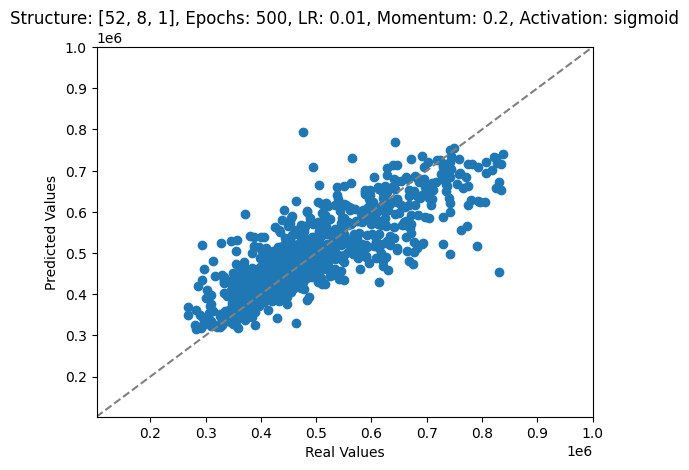

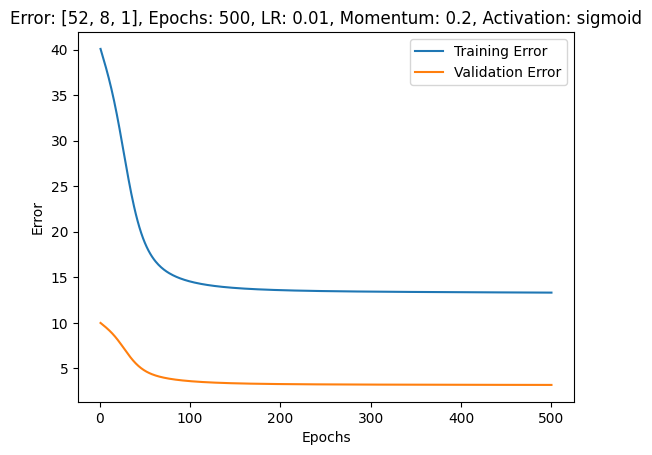

Training - epoch:  0 Error:  31.026352547137925
Validation - epoch:  0 Error:  7.363891386940012
Training - epoch:  1 Error:  27.50619078584904
Validation - epoch:  1 Error:  6.595069542727673
Training - epoch:  2 Error:  25.861020210408274
Validation - epoch:  2 Error:  6.258173588094567
Training - epoch:  3 Error:  24.276832236872494
Validation - epoch:  3 Error:  5.9372874058767025
Training - epoch:  4 Error:  22.754391598630463
Validation - epoch:  4 Error:  5.632376644759142
Training - epoch:  5 Error:  21.4149280512641
Validation - epoch:  5 Error:  5.366630143806298
Training - epoch:  6 Error:  20.329479171865916
Validation - epoch:  6 Error:  5.151161115595907
Training - epoch:  7 Error:  19.49395907528509
Validation - epoch:  7 Error:  4.981953630922515
Training - epoch:  8 Error:  18.858881973998148
Validation - epoch:  8 Error:  4.84749013398874
Training - epoch:  9 Error:  18.367684385757773
Validation - epoch:  9 Error:  4.73666527621012
Training - epoch:  10 Error:  17.97

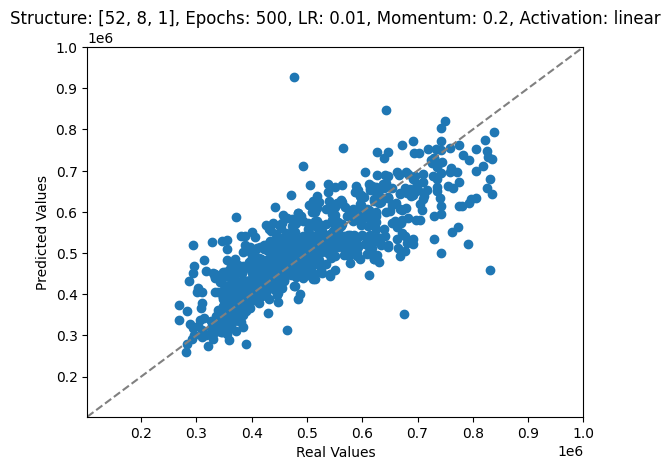

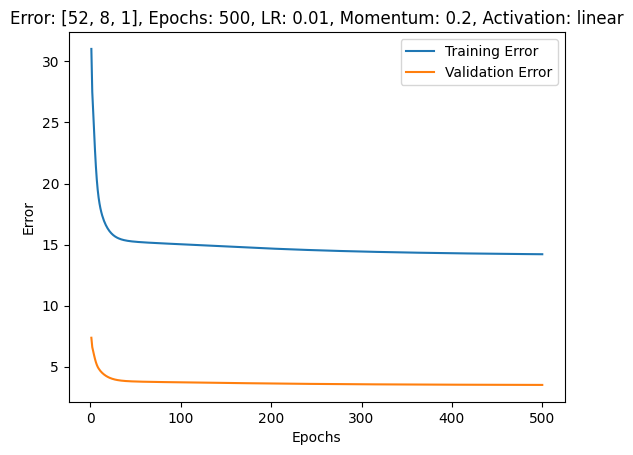

Training - epoch:  0 Error:  32.14366373474813
Validation - epoch:  0 Error:  8.089192843760287
Training - epoch:  1 Error:  28.84739224395761
Validation - epoch:  1 Error:  7.23557542683633
Training - epoch:  2 Error:  27.30769360228522
Validation - epoch:  2 Error:  6.85953029809206
Training - epoch:  3 Error:  26.26124825461982
Validation - epoch:  3 Error:  6.603388757914704
Training - epoch:  4 Error:  25.39531021528968
Validation - epoch:  4 Error:  6.389051823486178
Training - epoch:  5 Error:  24.58931740577826
Validation - epoch:  5 Error:  6.187745321557203
Training - epoch:  6 Error:  23.789710402198267
Validation - epoch:  6 Error:  5.986856193213354
Training - epoch:  7 Error:  22.975822826225087
Validation - epoch:  7 Error:  5.781657142770066
Training - epoch:  8 Error:  22.150381329948612
Validation - epoch:  8 Error:  5.573091077308339
Training - epoch:  9 Error:  21.33548261634191
Validation - epoch:  9 Error:  5.366803208203999
Training - epoch:  10 Error:  20.565359

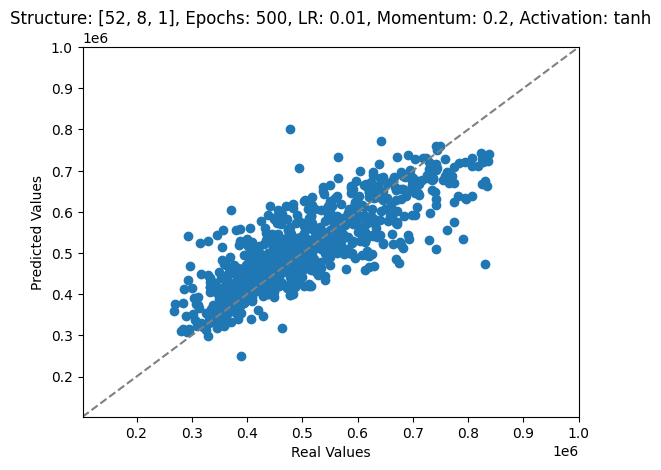

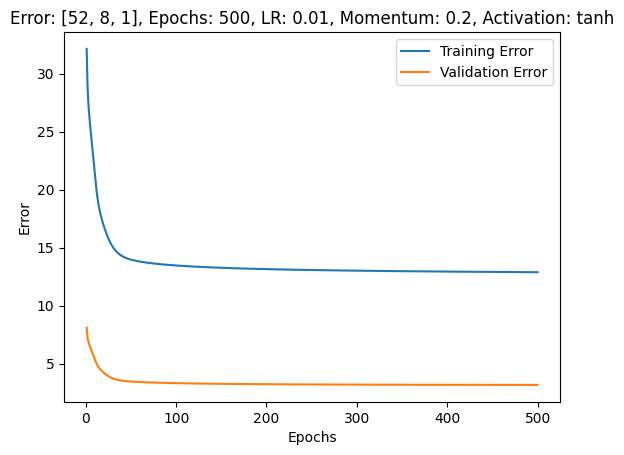

Training - epoch:  0 Error:  33.34779393900821
Validation - epoch:  0 Error:  9.184371837986639
Training - epoch:  1 Error:  28.209003607834493
Validation - epoch:  1 Error:  7.813871078389502
Training - epoch:  2 Error:  23.533804650118793
Validation - epoch:  2 Error:  6.552376128486599
Training - epoch:  3 Error:  20.137077052690888
Validation - epoch:  3 Error:  5.641692994601378
Training - epoch:  4 Error:  17.931638593379247
Validation - epoch:  4 Error:  5.0651975372450595
Training - epoch:  5 Error:  16.52516484860547
Validation - epoch:  5 Error:  4.7117388862346195
Training - epoch:  6 Error:  15.602153785411376
Validation - epoch:  6 Error:  4.490989166225021
Training - epoch:  7 Error:  14.969364757004838
Validation - epoch:  7 Error:  4.347935099256958
Training - epoch:  8 Error:  14.518621445616805
Validation - epoch:  8 Error:  4.252061785469423
Training - epoch:  9 Error:  14.188441527860196
Validation - epoch:  9 Error:  4.186268601029709
Training - epoch:  10 Error:  

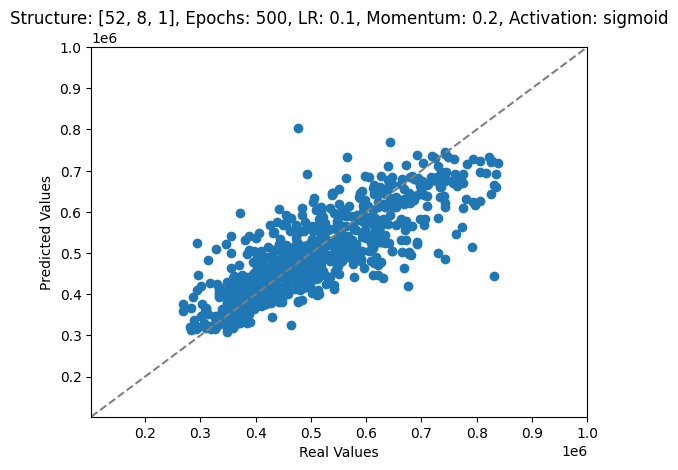

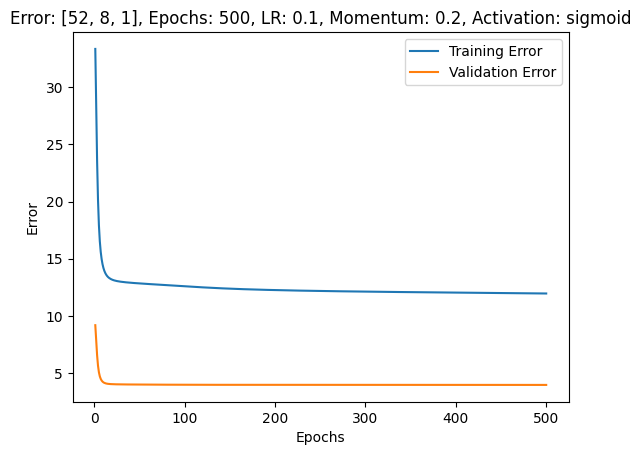

Training - epoch:  0 Error:  26.16439571119585
Validation - epoch:  0 Error:  6.596663212412031
Training - epoch:  1 Error:  21.876587886910734
Validation - epoch:  1 Error:  5.724739549387368
Training - epoch:  2 Error:  20.264529519128242
Validation - epoch:  2 Error:  5.413170137857836
Training - epoch:  3 Error:  19.725465838070438
Validation - epoch:  3 Error:  5.318125476254529
Training - epoch:  4 Error:  19.515433378926872
Validation - epoch:  4 Error:  5.282255917345607
Training - epoch:  5 Error:  19.40379943217796
Validation - epoch:  5 Error:  5.260606633905711
Training - epoch:  6 Error:  19.32520115023466
Validation - epoch:  6 Error:  5.242515404124887
Training - epoch:  7 Error:  19.262311055563643
Validation - epoch:  7 Error:  5.226278985022788
Training - epoch:  8 Error:  19.210609561530767
Validation - epoch:  8 Error:  5.212013298691243
Training - epoch:  9 Error:  19.168431139766227
Validation - epoch:  9 Error:  5.199892593348083
Training - epoch:  10 Error:  19.

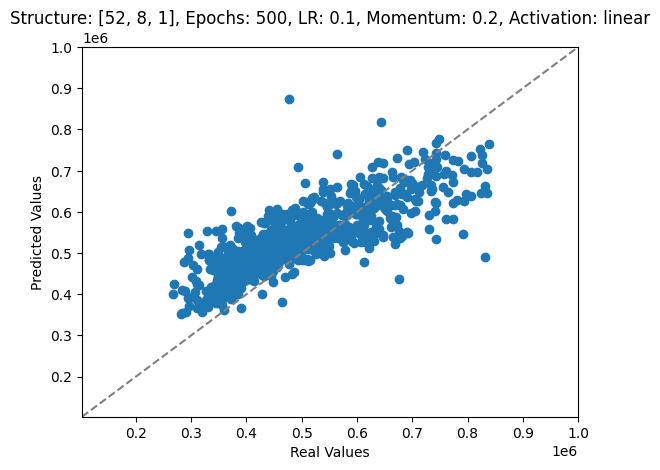

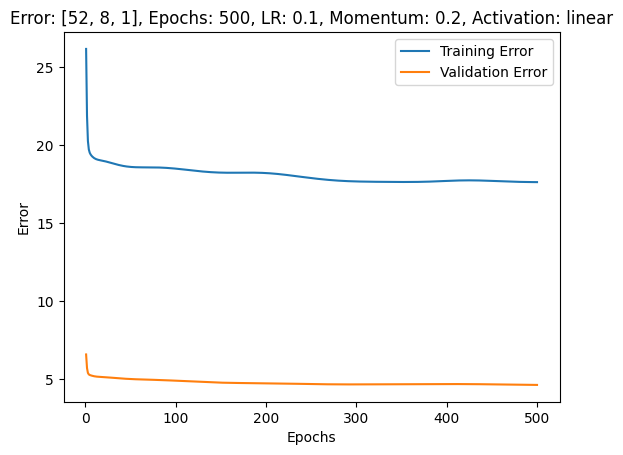

Training - epoch:  0 Error:  21.611660812546646
Validation - epoch:  0 Error:  5.163386150630194
Training - epoch:  1 Error:  18.089157622277185
Validation - epoch:  1 Error:  4.281337167886869
Training - epoch:  2 Error:  16.311866891993084
Validation - epoch:  2 Error:  3.7977465806297634
Training - epoch:  3 Error:  15.394742772903728
Validation - epoch:  3 Error:  3.541560623995654
Training - epoch:  4 Error:  14.873419293944758
Validation - epoch:  4 Error:  3.3978983565655207
Training - epoch:  5 Error:  14.545790572766888
Validation - epoch:  5 Error:  3.311441977241782
Training - epoch:  6 Error:  14.321847152543793
Validation - epoch:  6 Error:  3.255645402868492
Training - epoch:  7 Error:  14.157589127468743
Validation - epoch:  7 Error:  3.2175506077452263
Training - epoch:  8 Error:  14.030475981038045
Validation - epoch:  8 Error:  3.190737931520459
Training - epoch:  9 Error:  13.928226900550092
Validation - epoch:  9 Error:  3.1717383713463145
Training - epoch:  10 Erro

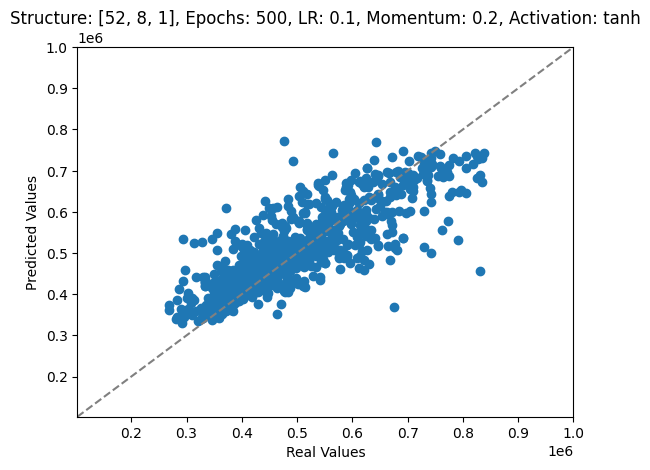

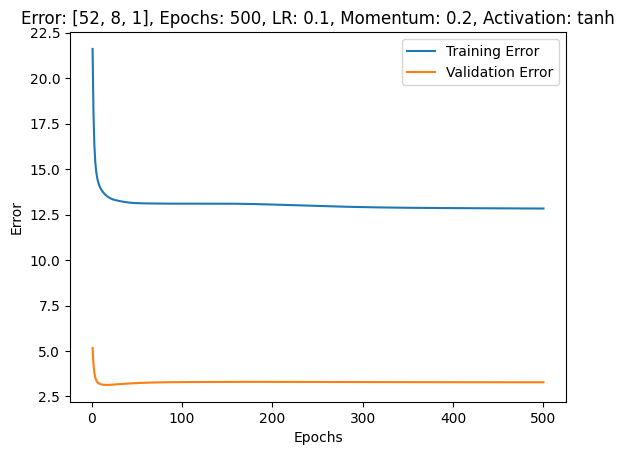

All Results:
[{'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.1, 'Momentum': 0.2, 'Activation': 'sigmoid', 'MAPE': 0.0990528299118738}, {'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.01, 'Momentum': 0.2, 'Activation': 'sigmoid', 'MAPE': 0.10212616636583252}, {'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.01, 'Momentum': 0.2, 'Activation': 'tanh', 'MAPE': 0.1039719042347798}, {'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.1, 'Momentum': 0.2, 'Activation': 'tanh', 'MAPE': 0.10579763011716305}, {'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.01, 'Momentum': 0.2, 'Activation': 'linear', 'MAPE': 0.10816307240342993}, {'Structure': [52, 8, 1], 'Epochs': 500, 'Learning Rate': 0.1, 'Momentum': 0.2, 'Activation': 'linear', 'MAPE': 0.1500158286104869}]
Best Hyperparameters:
   Structure  Epochs  Learning Rate  Momentum Activation      MAPE
0         52     500            0.1       0.2    sigmoid  0.099053
1          8     500        

In [7]:
# Read data from CSV file
df3 = pd.read_csv('data.csv', sep=",", decimal=".")

# Calculate z-scores for the 'price' column and filter out values with z-scores greater than 0.8 for data normalization
from scipy.stats import zscore
z_scores = zscore(df3["price"])
abs_z_scores = np.abs(z_scores)
df3 = df3[(abs_z_scores < 0.8)]

# Drop redundant columns from the DataFrame
df3 = df3.drop(["date", "waterfront", "view", "yr_built", "yr_renovated", "street", "statezip", "country"], axis=1)

# Check for missing values in the DataFrame (There are no missing values)
missing_values = df3.isnull().sum()

# Perform one-hot encoding for the 'city' column to get rid of categorical data
df3 = pd.get_dummies(df3, columns=['city'])
# Convert boolean values to integers (1 for True, 0 for False)
df3 = df3.astype(int)

# Separate features (x3) and target variable (y3)
x3, y3 = df3.drop(["price"], axis=1), df3[["price"]]

min = np.min(y3["price"])
max = np.max(y3["price"])

# Scale the features and target variable to the range [0, 1]
scaler = MinMaxScaler()
x3 = scaler.fit_transform(x3)
y3 = scaler.fit_transform(y3)
y3 = y3 * 0.8 + 0.1  # Transform y3 to the desired range [0.1, 0.9]

# Split the data into training and testing sets
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.2, random_state=42)

# Call the run_neural_network function
run_neural_network(x3_train, x3_test, y3_train, y3_test, min, max, "housing")